Выполнил: Seriy Nikita

## Контест 1. Шаг 1. Подготовка данных

### 1.1 Загрузка и очистка данных:
- [**+**] Загрузка датасета
- [**+**] Обработка выбросов
- [**+**] Обработка дубликатов

---

### 1.2 Обработка отсутствующих значений: 
- [**+**] Проверим количество пропусков в каждом признаке
- [**+**] Удаление строк с пропусками
---
- [-] Удаление столбцов с пропусками
- [-] Удаляем строки с NaN значениями в столбце
- [-] Удаляем столбцы
- [-] Заполнение пропусков средним значением
- [-] Заполнение медианой
- [-] Заполнение модой
- [-] Заполнение специальным значением
- [-] Заполнение *методом $k$-ближайших соседей*\*.


### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, TargetEncoder

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Обработка исходных колонок

- Заметим, что следующие категориальные столбцы имеют тип необрабатываемый тип object, который преобразуем с помощью one-hot encoding. 
- При этом колонку ApplicationDate можно удалить для получения более точного значения MSE (выявлено эмпирически).

| № | Column              | Non-null  | Count   | Dtype   |
|-------|----------------------|----------------|---------|--------|
| 0     | ApplicationDate       | 10487          | non-null| object |
| 6     | MaritalStatus         | 10487          | non-null| object |
| 8     | HomeOwnershipStatus   | 10487          | non-null| object |
| 15    | LoanPurpose           | 9986           | non-null| object |
| 26    | EmploymentStatus      | 10487          | non-null| object |
| 27    | EducationLevel        | 10487          | non-null| object |


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Удалим колонку ApplicationDate
df_train = df_train.drop(columns=['ApplicationDate'])


categorical_columns = [
    'MaritalStatus', 
    'HomeOwnershipStatus', 
    'LoanPurpose', 
    'EmploymentStatus', 
    'EducationLevel'
]
# One-Hot Encoding для категориальных признаков
df_train = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)

# Удаление дубликатов и всех строк с пропусками
df_train = df_train.dropna().drop_duplicates(keep='first')
df_test = df_test.dropna().drop_duplicates(keep='first')


print(df_train.info())
print(df_train.isnull().sum())  # смотрим на пропуски

<class 'pandas.core.frame.DataFrame'>
Index: 9529 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             9529 non-null   float64
 1   AnnualIncome                    9529 non-null   float64
 2   CreditScore                     9529 non-null   float64
 3   LoanAmount                      9529 non-null   float64
 4   LoanDuration                    9529 non-null   float64
 5   NumberOfDependents              9529 non-null   float64
 6   MonthlyDebtPayments             9529 non-null   float64
 7   CreditCardUtilizationRate       9529 non-null   float64
 8   NumberOfOpenCreditLines         9529 non-null   float64
 9   NumberOfCreditInquiries         9529 non-null   float64
 10  DebtToIncomeRatio               9529 non-null   float64
 11  BankruptcyHistory               9529 non-null   float64
 12  PreviousLoanDefaults            9529 no

## Визуализация распределения признаков: 
- [**+**] Визуализация матрицы корреляций с помощью тепловой карты
- [**+**] Рассмотрены признаки с сильной корреляцией (выше 0.7) 
- [**+**] Анализ зависимости
- [**+**] Выявление выбросов

## Анализ зависимости
- Построение матрицы сильно коррелирующих признаков позволит выявить мультиколлинеарность.
- Признаки с высокой корреляцией могут содержать дублирующую информацию, снижающую эффективность модели.

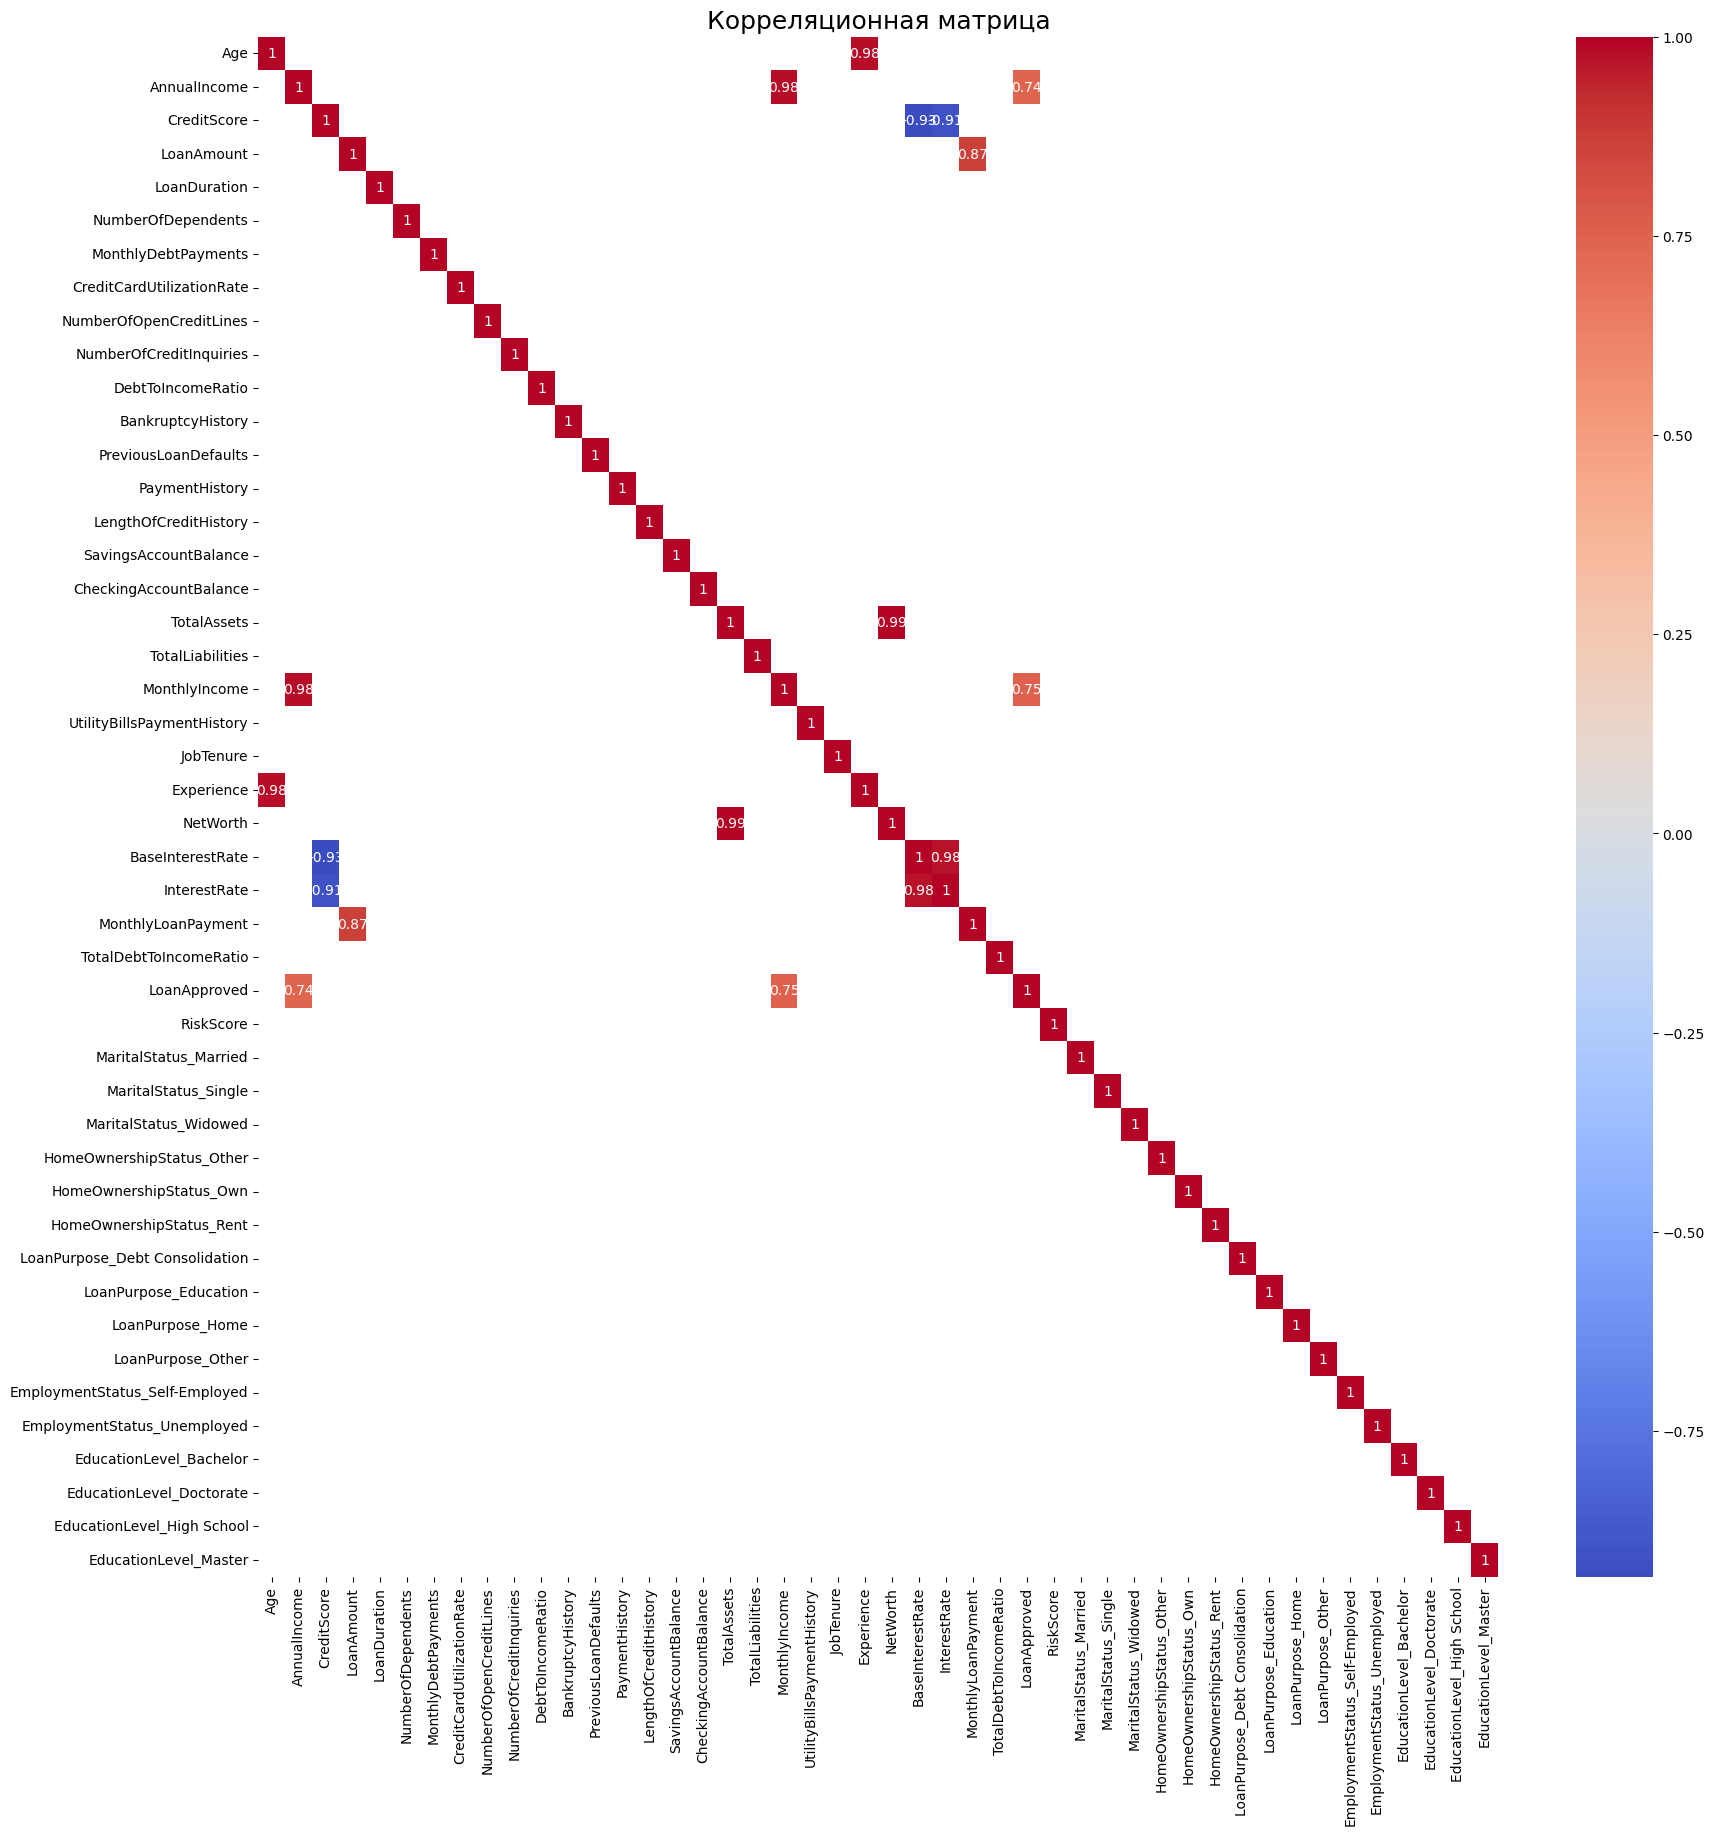

In [4]:
correlation_matrix = df_train.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix[correlation_matrix.abs() >= 0.7], annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица", fontsize=18)
plt.show()

In [5]:
# Вывод матрицы с сильной положительной корреляцией, убрав лишние NaN и пары для наглядности 
high_positive_correlation_matrix = correlation_matrix[(correlation_matrix.abs() >= 0.7) & (correlation_matrix != 1.0)].stack()
print(high_positive_correlation_matrix)


Age                 Experience            0.982835
AnnualIncome        MonthlyIncome         0.984377
                    LoanApproved          0.742279
CreditScore         BaseInterestRate     -0.932792
                    InterestRate         -0.909006
LoanAmount          MonthlyLoanPayment    0.868396
TotalAssets         NetWorth              0.993873
MonthlyIncome       AnnualIncome          0.984377
                    LoanApproved          0.754917
Experience          Age                   0.982835
NetWorth            TotalAssets           0.993873
BaseInterestRate    CreditScore          -0.932792
                    InterestRate          0.975232
InterestRate        CreditScore          -0.909006
                    BaseInterestRate      0.975232
MonthlyLoanPayment  LoanAmount            0.868396
LoanApproved        AnnualIncome          0.742279
                    MonthlyIncome         0.754917
dtype: float64


In [6]:
# Удалим признаки так, исключив линейные зависимости
# В случае зависимости категориальных признаков от некатегориальных будем стараться оставлять категориальные


df_train = df_train.drop(
    [
        'Experience',
        'MonthlyIncome',
        'AnnualIncome',
        'InterestRate',
        'BaseInterestRate',
        'MonthlyLoanPayment',
        'TotalAssets'
    ],
    axis=1
)

df_test = df_test.drop(
    [
        'Experience',
        'MonthlyIncome',
        'AnnualIncome',
        'InterestRate',
        'BaseInterestRate',
        'MonthlyLoanPayment',
        'TotalAssets'
    ],
    axis=1
)



## Поиск выбросов
- Чтобы повысить точность предсказания переменной RiskScore, построим для неё гистограмму и выявим выбросы.

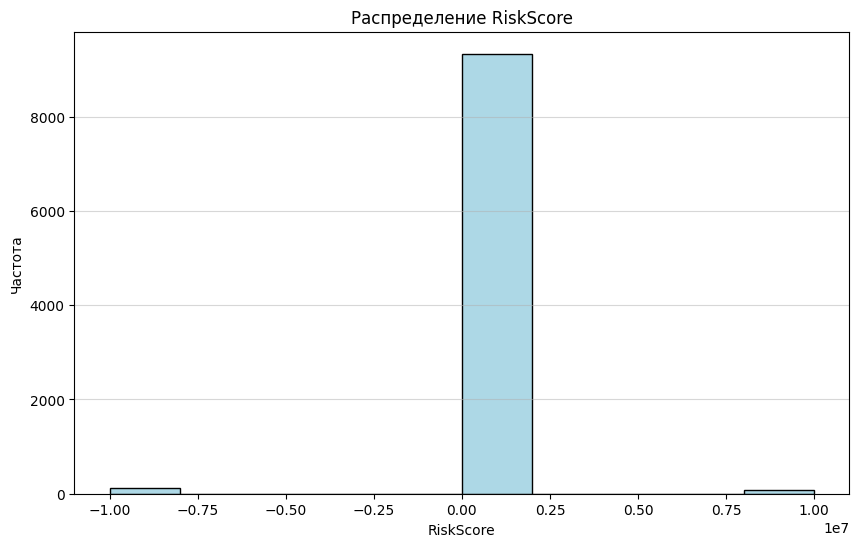

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df_train['RiskScore'], bins=10, color='lightblue', edgecolor='black')
plt.title('Распределение RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.show()

## Удалим выбросы
- Сделаем это, оставив значения RiskScore в диапазоне (0-100)

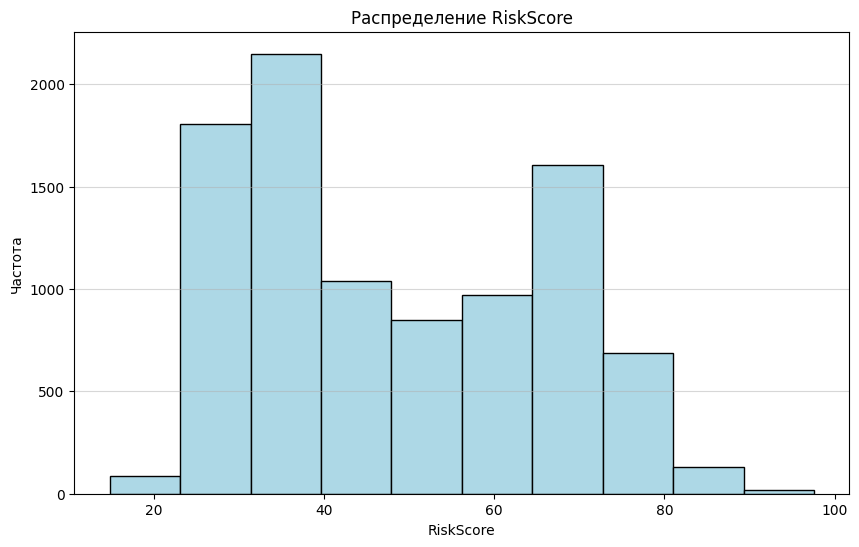

In [8]:
df_train = df_train[(df_train['RiskScore'] >= 0) & (df_train['RiskScore'] <= 100)]
plt.figure(figsize=(10, 6))
plt.hist(df_train['RiskScore'], bins=10, color='lightblue', edgecolor='black')
plt.title('Распределение RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.show()

# ***Лабораторная работа №2***

## Задание 1: Реализация собственного классификатора
 1) Написать класс, реализующий свой линейный классификатор и логистическую регрессию с методами fit и predict.

In [ ]:
class CustomClassifier:
    def __init__(self, method='linear', lr=0.01, epochs=1000):
        """
        Инициализация классификатора.

        :param method: 'linear' для линейного классификатора, 'logistic' для логистической регрессии
        :param lr: Скорость обучения
        :param epochs: Количество итераций для обучения
        """
        self.method = method
        self.lr = lr
        self.epochs = epochs
        self.weights = None

    def sigmoid(self, z):
        """Сигмоидальная активационная функция."""
        return 1 / (1 + np.exp(-z))

    def activation(self, z):
        """Активационная функция, в зависимости от выбранного метода."""
        if self.method == 'logistic':
            return self.sigmoid(z)
        return z

    def fit(self, X, y):
        """
        Обучение модели с использованием градиентного спуска.

        :param X: Матрица признаков (размер n_samples x n_features)
        :param y: Вектор целевой переменной (размер n_samples)
        """
        # Добавляем столбец единиц для учёта смещения (bias)
        X = np.c_[np.ones(X.shape[0]), X]
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        for epoch in range(self.epochs):
            # Линейное преобразование
            linear_output = np.dot(X, self.weights)
            # Активация
            predictions = self.activation(linear_output)
            # Ошибка
            errors = y - predictions
            # Градиент
            gradient = -np.dot(X.T, errors) / n_samples
            # Обновление весов
            self.weights -= self.lr * gradient

    def predict(self, X, return_proba=False):
        """
        Предсказание меток или вероятностей.

        :param X: Матрица признаков (размер n_samples x n_features)
        :param return_proba: Если True, возвращает вероятности, иначе метки классов
        :return: Предсказанные метки классов или вероятности
        """
        # Добавляем столбец единиц для учёта смещения (bias)
        X = np.c_[np.ones(X.shape[0]), X]
        # Линейное преобразование
        linear_output = np.dot(X, self.weights)
        # Активация
        predictions = self.activation(linear_output)
        if return_proba:
            return predictions
        return (predictions > 0.5).astype(int)

## Задание 2: Решить задачу с помощью готовых реализаций
2. Необходимо решить задачу бинарной классификации на датасете из контеста №1 относительно целевой переменной ***LoanApproved***.

- [+] SVM: sklearn
- [+] Решающее дерево: sklearn
- [+] Случайный лес: sklearn
- [+] Градиентный бустинг: sklearn, LightGBM, XGBoost, catboost

- Доп: AdaBoost, NaiveBayes, GridSearchCV

## Задание 3: Посчитать метрики

- [+] precision, recall, F1-меру, accuracy для всех решений
- [+] визуализировать ***confusion matrix*** для всех решений 

## Предобработка данных: 
- Проводится обработка выбросов
- Преобразуются категориальные признаки в числовые с помощью One-Hot Encoding.
- При сильной корреляции создаются новые признаки для улучшения обучения (нелинейные комбинации или дополнительные переменные)


In [14]:
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def preprocess_data(df, drop_columns, categorical_columns):

    drop_columns = [col for col in drop_columns if col in df.columns]
    df = df.drop(columns=drop_columns)

    categorical_columns = [col for col in categorical_columns if col in df.columns]
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    df = df.dropna().drop_duplicates(keep='first')
    return df

print("Columns in df_train:", df_train.columns)


def handle_outliers_and_create_features(df):
    df = df[(df['RiskScore'] >= 0) & (df['RiskScore'] <= 100)].copy() 
    df.loc[:, 'Loan_per_ages'] = df['Age'] * df['LoanApproved']
    df.loc[:, 'NetWorth_within_age'] = df['Age'] * df['NetWorth']
    return df


def binarize_target(y, threshold):
    return (y > threshold).astype(int)

Columns in df_train: Index(['Age', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalLiabilities',
       'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth',
       'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'MaritalStatus_Widowed', 'HomeOwnershipStatus_Other',
       'HomeOwnershipStatus_Own', 'HomeOwnershipStatus_Rent',
       'LoanPurpose_Debt Consolidation', 'LoanPurpose_Education',
       'LoanPurpose_Home', 'LoanPurpose_Other',
       'EmploymentStatus_Self-Employed', 'EmploymentStatus_Unemployed',
       'EducationLevel_Bachelor', 'EducationLevel_Doctorate',
       'EducationLevel_Hig

In [16]:
# 1. Предобработка данных
df_train = preprocess_data(
    df_train, 
    drop_columns=[],  # Пустой список, так как `ApplicationDate` уже удалена
    categorical_columns=['MaritalStatus', 'LoanPurpose']
)
df_train = handle_outliers_and_create_features(df_train)

# 2. Разделение данных
X = df_train.drop(columns=['RiskScore'])
y = df_train['RiskScore']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=25, stratify=binarize_target(y, threshold=50)
)

# 3. Бинаризация
y_train_binary = binarize_target(y_train, threshold=np.median(y_train))
y_test_binary = binarize_target(y_test, threshold=np.median(y_train))

# 4. Диагностика
print("Unique values in y_train_binary:", np.unique(y_train_binary, return_counts=True))
print("Unique values in y_test_binary:", np.unique(y_test_binary, return_counts=True))


Unique values in y_train_binary: (array([0, 1]), array([4199, 4199]))
Unique values in y_test_binary: (array([0, 1]), array([476, 458]))


Training CatBoost...
CatBoost Metrics:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       476
           1       0.96      0.95      0.96       458

    accuracy                           0.96       934
   macro avg       0.96      0.96      0.96       934
weighted avg       0.96      0.96      0.96       934



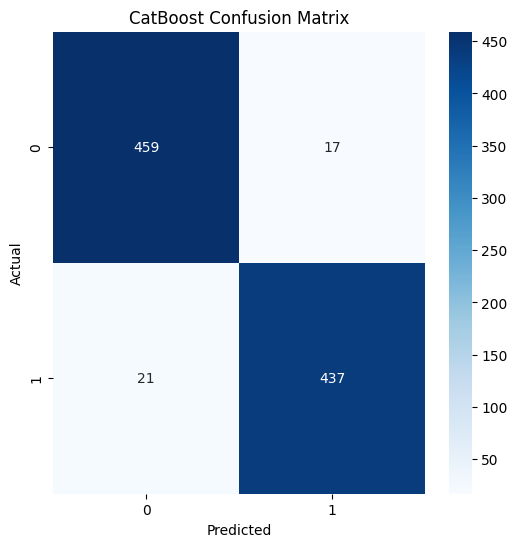

Training DecisionTree...
DecisionTree Metrics:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       476
           1       0.96      0.94      0.95       458

    accuracy                           0.95       934
   macro avg       0.95      0.95      0.95       934
weighted avg       0.95      0.95      0.95       934



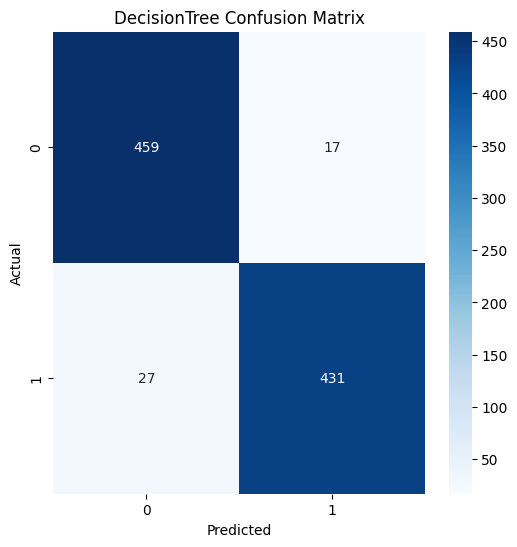

Training SVM...
SVM Metrics:
              precision    recall  f1-score   support

           0       0.67      0.32      0.43       476
           1       0.54      0.84      0.66       458

    accuracy                           0.57       934
   macro avg       0.61      0.58      0.54       934
weighted avg       0.61      0.57      0.54       934



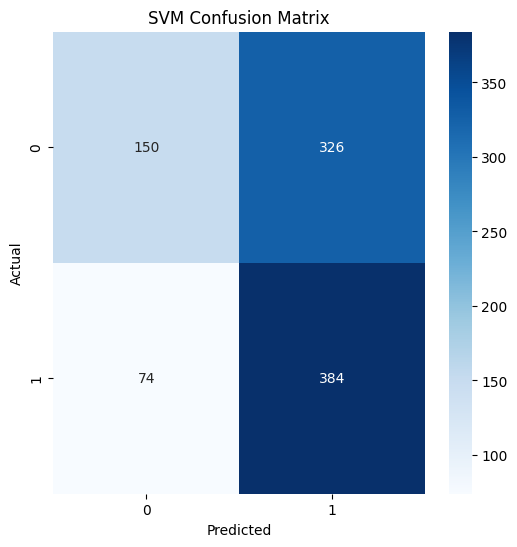

Training XGBoost...
XGBoost Metrics:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       476
           1       0.95      0.97      0.96       458

    accuracy                           0.96       934
   macro avg       0.96      0.96      0.96       934
weighted avg       0.96      0.96      0.96       934



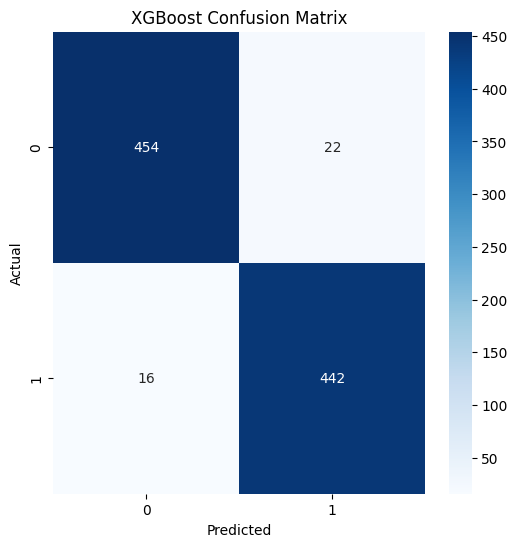

Training LightGBM...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4199, number of negative: 4199
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3328
[LightGBM] [Info] Number of data points in the train set: 8398, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

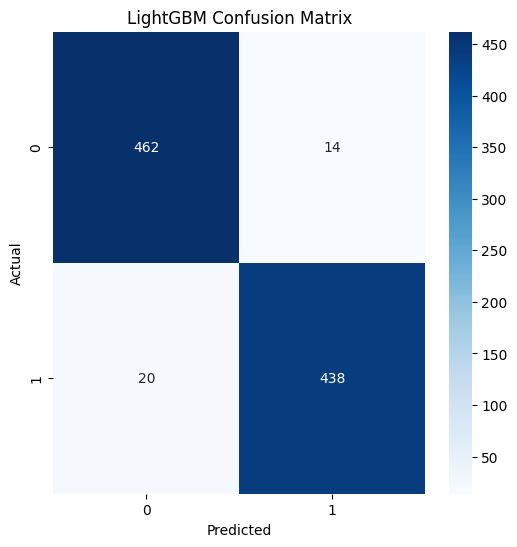

Training AdaBoost...


/home/snowwy/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Metrics:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       476
           1       0.96      0.95      0.95       458

    accuracy                           0.95       934
   macro avg       0.95      0.95      0.95       934
weighted avg       0.95      0.95      0.95       934



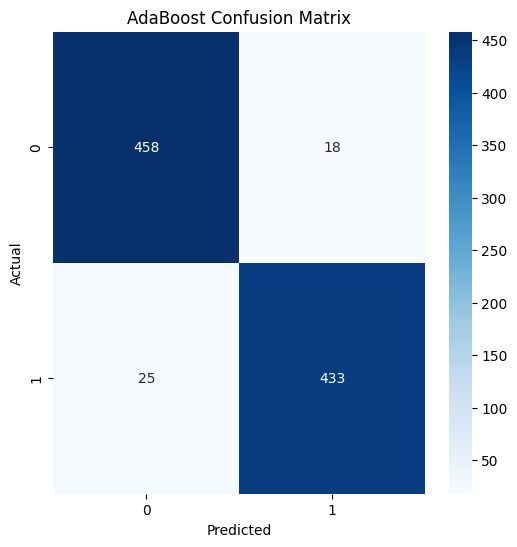

Training NaiveBayes...
NaiveBayes Metrics:
              precision    recall  f1-score   support

           0       0.70      0.16      0.26       476
           1       0.52      0.93      0.66       458

    accuracy                           0.54       934
   macro avg       0.61      0.54      0.46       934
weighted avg       0.61      0.54      0.46       934



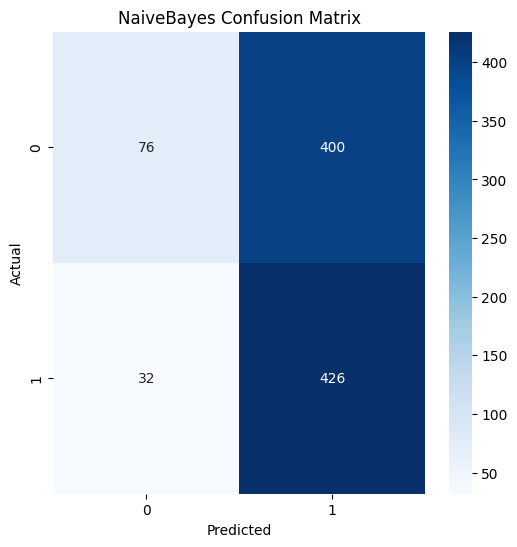

Training LogisticRegression...
LogisticRegression Metrics:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       476
           1       0.80      0.74      0.77       458

    accuracy                           0.78       934
   macro avg       0.78      0.78      0.78       934
weighted avg       0.78      0.78      0.78       934



/home/snowwy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


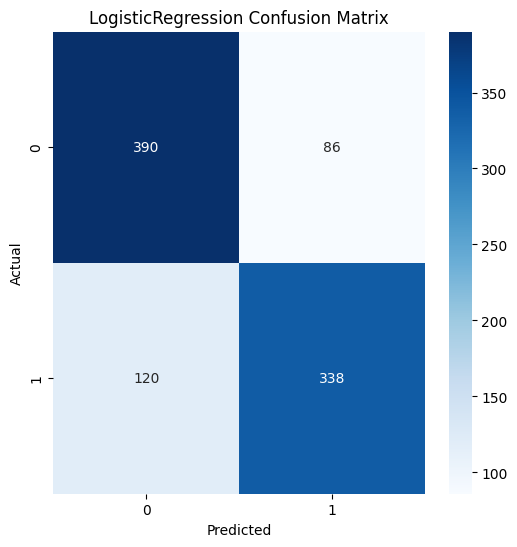

In [17]:
def plot_confusion_matrix(cm, labels=['0', '1'], title='Confusion Matrix'):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

models = {
    'CatBoost': CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'SVM': SVC(probability=True, kernel='rbf', C=1.0, class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6),
    'LightGBM': LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000),
}

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train_binary)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test_binary, y_pred)
    metrics = classification_report(y_test_binary, y_pred, output_dict=True)

    print(f"{name} Metrics:")
    print(classification_report(y_test_binary, y_pred))
    plot_confusion_matrix(cm, title=f"{name} Confusion Matrix")

/home/snowwy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/snowwy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Лучшие параметры: {'C': 0.01, 'solver': 'lbfgs'}
Metrics after GridSearchCV:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       476
           1       0.92      0.87      0.89       458

    accuracy                           0.90       934
   macro avg       0.90      0.90      0.90       934
weighted avg       0.90      0.90      0.90       934



/home/snowwy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


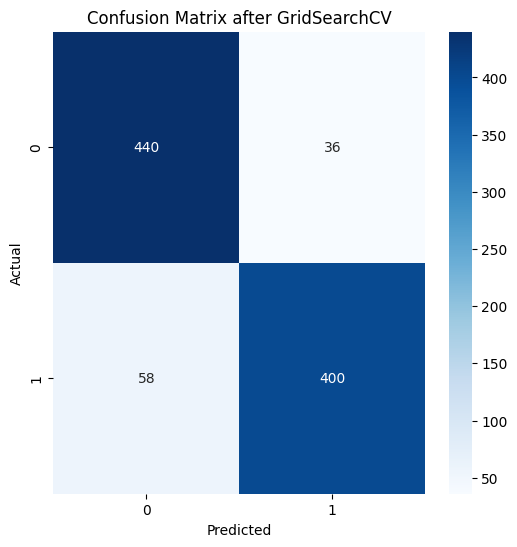

In [19]:
from sklearn.model_selection import GridSearchCV

# Сетка гиперпараметров
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Регуляризация
    'solver': ['liblinear', 'lbfgs']  # Алгоритм оптимизации
}

grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), 
                           param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train_binary)

best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

y_pred = best_model.predict(X_test)
print("Metrics after GridSearchCV:")
print(classification_report(y_test_binary, y_pred))

cm = confusion_matrix(y_test_binary, y_pred)
plot_confusion_matrix(cm, title="Confusion Matrix after GridSearchCV")

## Задание 4: Выводы
